[<img src='https://vermontcomplexsystems.org/index_files/large-526602.png' width="180" height="150" align="center"/>](https://vermontcomplexsystems.org/)


**CSYS 303:** Complex Networks

**Name:** Patrick L. Harvey

**Date:** 20230228

**Report:** Available on [Overleaf](https://www.overleaf.com/read/jwptqkrxjbkr) or [GitHub](https://github.com/P-Harvey/WebLaTex/blob/a6ff861fc8e49981e7c4deb5417826cbfd124951/CSYS_303_Complex_Networks/assignment20.tex)

****

**Description:** 
This notebook applies [methods](https://arxiv.org/abs/2008.02250) developed by members of the Vermont Complex Systems Center to examine sentiment 
(specifically happiness) for a given text or corpus. 
The specific text examined in this implementation of their methods is Cormac McCarthy's *Blood Meridian* which is freely available as a PDF [here](https://altair.pw/pub/lib/Cormac%20Mccarthy%20-%20The%20Blood%20Meridian.pdf).
Adobe Acrobat Pro was used to convert the PDF document to a plain text (.txt) file.

****

**Index**

[Setup](#Setup)

1. [Imports](#Imports)

2. [Functions](#Functions)

[Assignment 20](#Assignment_20)

1. [Part 1](#Question_1)

$\qquad$ a. [Text Destruction](#Part_1a)

$\qquad$ b. [Time-Series](#Part_1b)

$\qquad$ c. [Lensed Time-Series](#Part_1c)

2. [Part 2](#Question_2)

$\qquad$ a. [](#Part_2a)

$\qquad$ b. [](#Part_2b)

$\qquad$ c. [](#Part_2c)

$\qquad$ d. [](#Part_2d)

$\qquad$ e. [](#Part_2e)

$\qquad$ f. [](#Part_2f)

4. [Appendices](#Appendices)

  $\qquad$ a. [Hedonometer API](#Hedonometer_API) 

  $\qquad$ b. [Citations and References](#Citations_and_References)

****

# Setup
<a id='Setup'></a>

In [1]:
source: str = 'Blood_Meridian_McCarthy.txt'

## Imports
<a id='Imports'></a>

In [2]:
""" Run the latest and greatest """
%pip install -r requirements.txt --upgrade

""" Import them all """
import itertools
import json
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
import plotly
import re
import requests
import seaborn as sns
import string
from string import punctuation as punct
import sys

""" Sometimes ignorance = bliss """
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

""" In case Computer Modern Roman size 10 isn't an option. """
# mpl.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

""" Set default font for plots. """
mpl.rc('font',
       family = 'serif',
       serif = 'cmr10')

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Functions
<a id='Functions'></a>

In [8]:
def load_text(f: str = '/content/text.txt',
              prnt: bool = False):
  with open(f) as txt:
    gram_list = re.findall(r"\w+[^\s\.,?!;]+|\w+|[\.,?!;]",
                           ''.join(txt.readlines()))
    if prnt:
      print(f"Total n-grams: {len(np.array(gram_list)):>14,}")
  return np.array(gram_list)

def get_word_freq(f: str = '/content/text.txt',
                  prnt: bool = False):
  n_gram_vec = load_text(f)
  freq = np.array(np.unique(n_gram_vec, return_counts=True, axis=None))
  if prnt:
    print(f'Total unique n-grams: {len(np.array(freq[1])):>7,}')
  return freq, n_gram_vec

def plot_zipf(f: str = '/content/text.txt'):
  freq = load_text(f)
  plt.scatter(x = np.linspace(len(freq),1,len(freq)), 
              y = freq,
              s = 2,
              c = 'k',
              alpha = 0.8,
              linewidths=0.)
  plt.xscale('log')
  plt.yscale('log')
  plt.suptitle('Blood Meridian by Cormac McCarthy',
              fontsize = 16)
  plt.title('Rank-Frequency (Zipf) Plot')
  plt.xlabel(r'log$_{10}$(Rank)')
  plt.ylabel(r'log$_{10}$(Frequency)')
  sns.despine()
  plt.show()

def subdue_ts_df(df, dh):
  return [i for i in df if i <= df.mean() - dh or i <= df.mean() + dh]

def gen_ts_df(source: str = 'Blood_Meridian_McCarthy.txt'):
  ts = np.char.lower(load_text(source, False))
  sentiment_lmt1 = pd.read_table('./dataset_s1.tsv')
  sentiment_lmt1.set_index(sentiment_lmt1['word'], inplace = True)
  ind_list = [sentiment_lmt1.index.get_loc(word) for word in ts if word in sentiment_lmt1.index]
  return sentiment_lmt1.iloc[ind_list]['happiness_average']

def gen_ts_plot(ts_df: pd.core.frame.DataFrame = None):
  fig, ax = plt.subplots(1,1,figsize=(20,5),dpi=250)
  ts_df.plot(linewidth=0.05, alpha = 0.95, ax = ax)
  ax.set_xticklabels([int(i) for i in np.linspace(1,len(ts_df), 8)])
  plt.show()

def gen_ts_windows(ts_df: pd.core.frame.DataFrame = None,
                   window: list = None,
                   delta_h: bool = False):
  
  rolling_ts_df = pd.DataFrame()

  if window is None:
    window = [10**1, 10**1.5, 10**2, 10**2.5, 10**3, 10**3.5, 10**4]

  if delta_h:
    delt_h = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

    for w, i in itertools.product(window, delt_h):
      temp = pd.Series(subdue_ts_df(ts_df, i))
      rolling_ts_df[[str(w), str(i)]] = temp.rolling(int(w)).sum() / w

      # rolling_ts_df[str(w), str(i)].plot(figsize=(10,4))

  else:
    for w in window:
      rolling_ts_df[str(w)] = ts_df.rolling(int(w)).sum() / w

  T = len(window)

  if delta_h:
    T += len(delt_h)
    print(T)

  fig, axs = plt.subplots(T,1,
                          figsize = (3.5, 9),
                          dpi = 180)

  for i, ax in enumerate(axs):
    if delta_h:
      rolling_ts_df[[str(window[i]), str(delt_h[i])]].plot(ax = ax,
                                        color='maroon',
                                        linewidth = 0.5,
                                        alpha = 0.8)

      n = len(rolling_ts_df[str(window[i]), str(delt_h[i])])

    else:
      rolling_ts_df[str(window[i])].plot(ax = ax,
                                         color='maroon',
                                         linewidth = 1/3,
                                         alpha = 2/3)
      
      n = len(rolling_ts_df[str(window[i])])

    ticks = [int(i) for i in np.linspace(1, n, 6)]
    ax.set_title(f'T={int(window[i])}',
                fontsize = 7)

    if i == 0:
      plt.suptitle('Average Lexical Happiness\nBlood Meridian by Cormac McCarthy (1985)',
                   fontsize = 10)
      ax.set_title('T = 10',
                   fontsize = 7)

    if i == 3:
      ax.set_ylabel('h'+r'$_{avg}$',
                    fontsize = 10)
      ax_tick_fmt(ax, ticks)

    if i == T-1:
      ax.set_xticks(ticks)
      ax.set_xticklabels(ticks,
                         fontsize = 6)
      plt.xlabel('Word Index',
                 fontsize = 10)
      
    else:
      ax_tick_fmt(ax, ticks)

  fig.tight_layout()
  plt.show()

def ax_tick_fmt(ax, ticks):
  ax.set_xticks(ticks)
  ax.set_xticklabels([])
  ax.set_xlabel('')

def test_str(n_gram: np.ndarray = None,
             prnt: bool = True):
  test_str = ' '.join(n_gram)
  if prnt:
    print(test_str)
  elif test_str:
    print("Non-zero string created.")
  else:
    print('You probably messed up. Try again!')

##########################################################################################

""" If running in Google Colab. Just don't. """
# def mount_drive():
#   from google.colab import drive
#   drive.mount('/content/drive/', force_remount = True)

def hedo_api():
    """
    API Links:
    https://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2
    """

    fmt   = 'json'
    date  = '2018-01-01'
    limit = '10000'
    base = f'http://hedonometer.org/api/v1/events/?format={fmt}&'
    uri = f'{base}happs__timeseries__title=en_all&'
    uri = f'{uri}happs__date__gte={date}&limit={limit}'
    req   = requests.get(uri)
    return pd.DataFrame(json.loads(req.content)['objects'])

def split_hedo_df(happiness_df: pd.core.frame.DataFrame = hedo_api()):
    date = np.array([i['date'] for i in happiness_df['happs']])
    freq = np.array([i['frequency'] for i in happiness_df['happs']])
    haps = np.array([i['happiness'] for i in happiness_df['happs']])
    time = np.array([i['timeseries'] for i in happiness_df['happs']])
    return date, freq, haps, time

# Assignment 20
<a id='Assignment_20'></a>

## Question 1
<a id='Question_1'></a>

****

Using the main text you chose at the start of the semester, plot a time-series of happiness as described below using the labMT lexicon definitions of sentiment.

The labMT lexicon is referenced in Peter S. Dodds' et. al. 2011 [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752&type=printable). 

The lexicon has been occasionally upgraded to accommodate major changes in language use.

****

**Notes:**

• The horizontal axis is “narrative time” corresponding to 1-grams in the text, running from $1 \to N$.

• The windows should overlap, sliding one word ahead each time This is a simple averaging filter.

• Points should be located above the center of each window.

• So the point for the window running from $n$ to $n+T −1$ (T words) will be located at $n + (T − 1)/2$.

• Do not pre-filter the text for any given lens. Windows will contain variable numbers of words with and without happiness scores.

****

### Part a.
<a id='Part_1a'></a>

****

Process (or destroy) your text so that it is a simple text file with one 1-gram per line—a vector of 1-grams.

To the extent possible, keep punctuation in as separate 1-grams. Periods, commas, semicolons, em-dashes, ellipses,

****

In [5]:
wf, ng = get_word_freq(source, True)

Total unique n-grams:  11,302


### Part b.
<a id='Part_1b'></a>

****

First, use the full lexical lens provided by labMT.

Make a single figure containing a stacked set of 7 plots with text windows of
sizes:

$T = [10^z]$ for $z = 1, 1.5, 2, 2.5, 3, 3.5,$ and $4.0$.

Stacked here means separated and stacked vertically, as opposed to directly
overlaid. 

See examples for Moby Dick at the end of this assignment. 

The notation [$\cdot$] implying that we round to the nearest integer.

*****

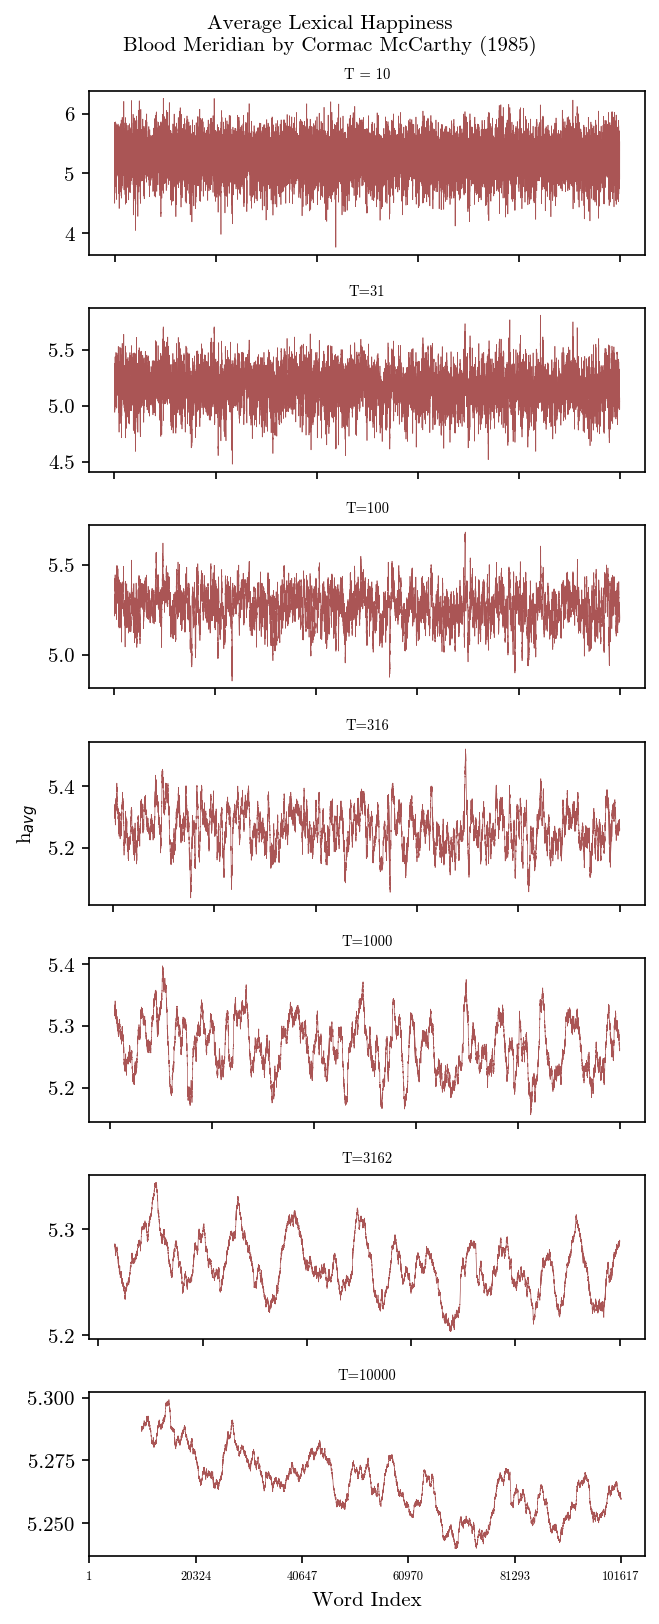

In [6]:
ts_df = gen_ts_df(source)
gen_ts_windows(ts_df, window = None, delta_h = False)

### Part c.
<a id='Part_1c'></a>

****

Repeat the above for lenses which exclude the central words around the neutral point.

The blocked words are $h_{avg} \pm \delta h_{avg}$ where $\delta h_{avg} = 0.5, 1.0, 1.5, 2.0, 2.5, 3.0,$ and $3.5$.

****

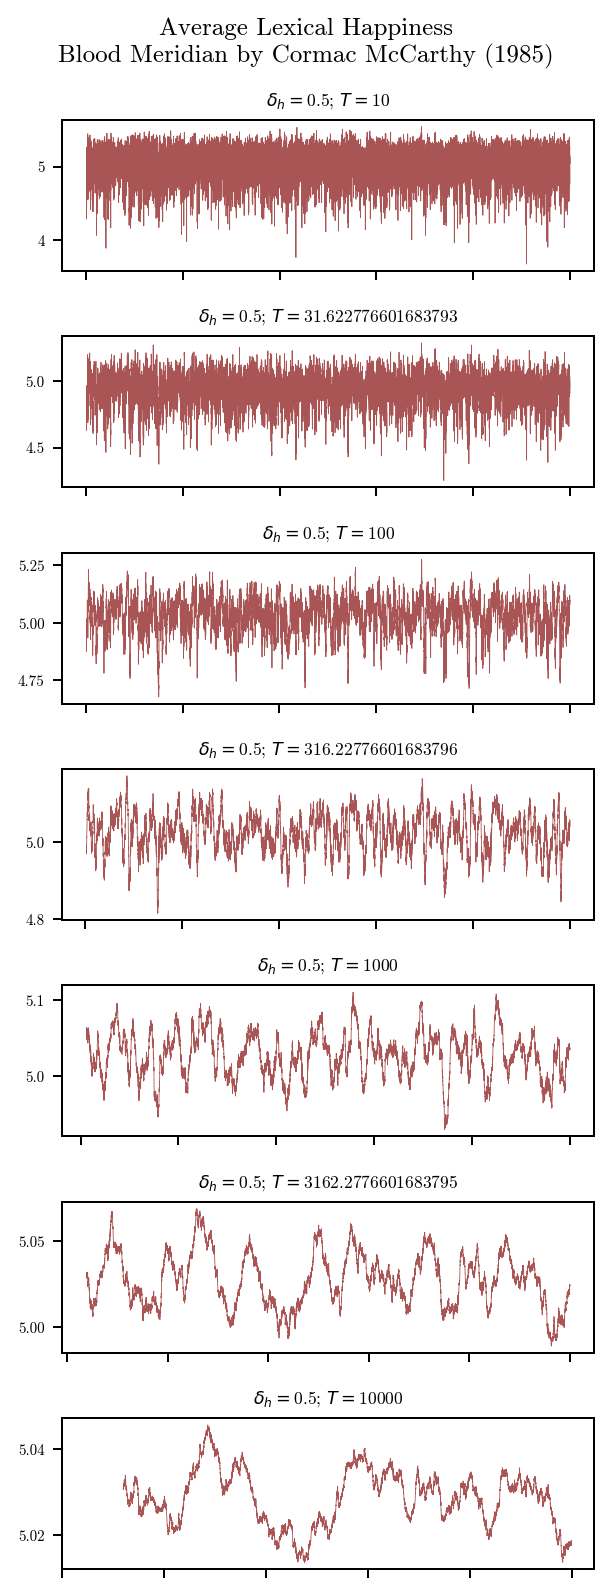

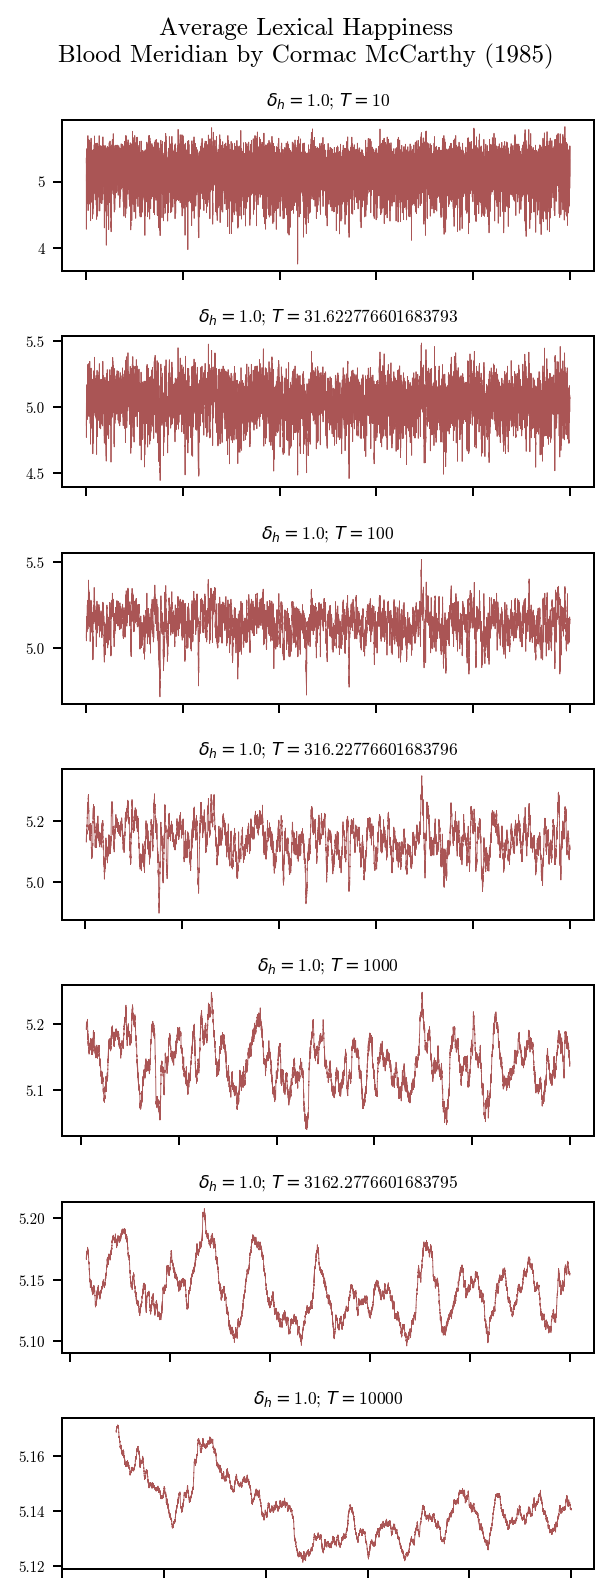

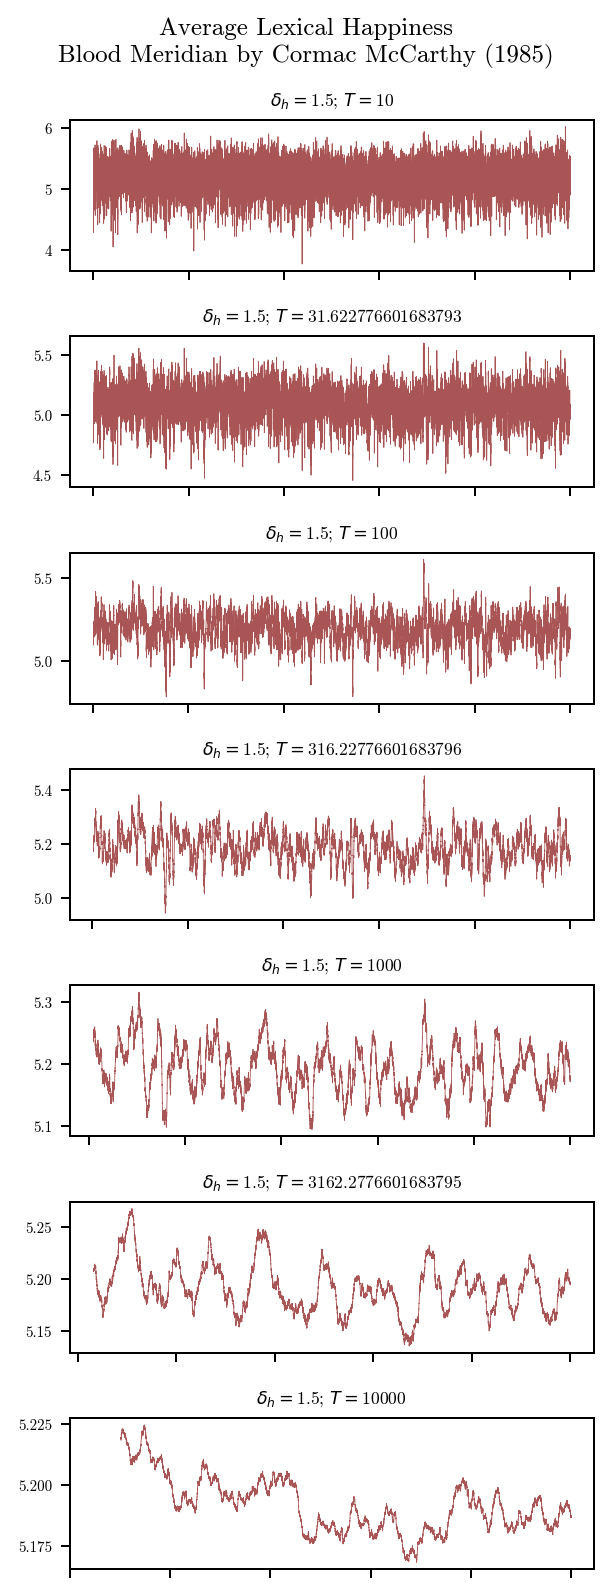

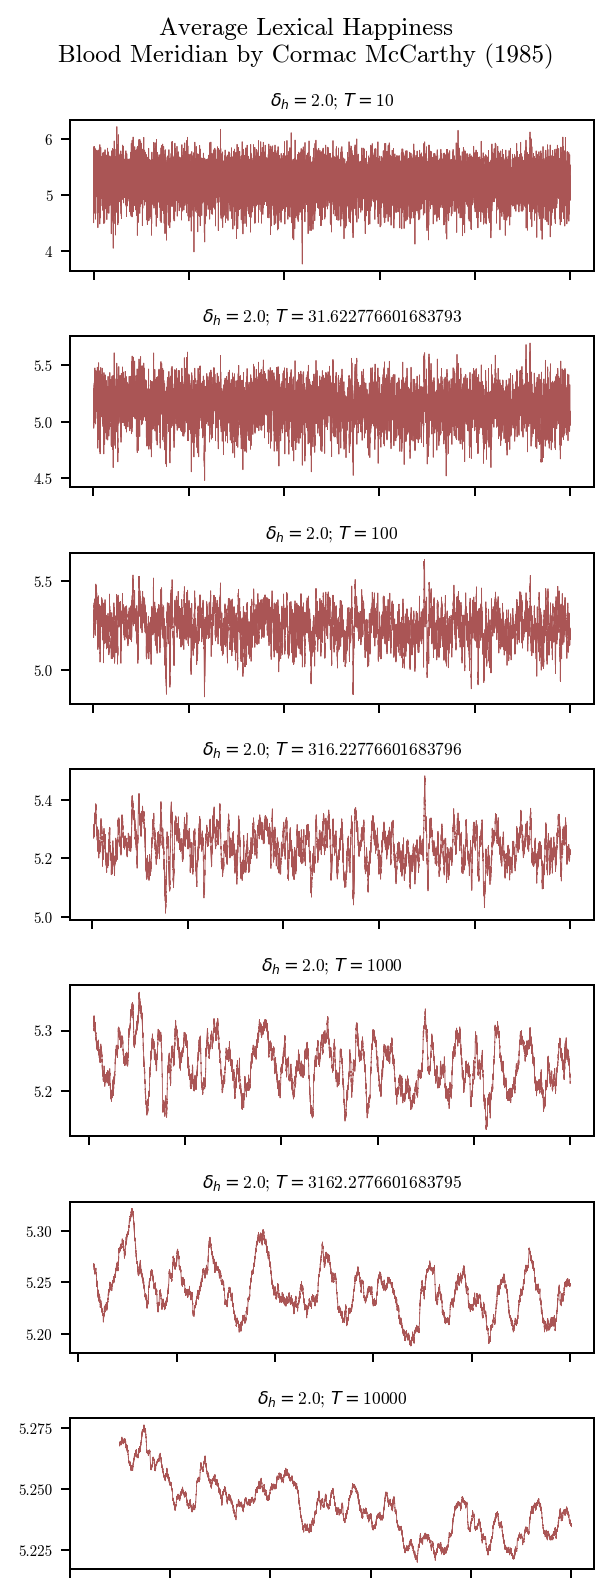

Bad pipe message: %s [b'laG\xc3*9\xbbs\x1e\xe8;F\xdf\x10\xcdD\xc5\x94 \xf0\xd3\xd1ew\x07\x95\x06\xa8(\xad\x12\x87\xde\x16\x03\xc8h\xfb\x1e\x9a\x97\x80\xd1\xc3=\xa3\\^\x8cM\xce\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16']
Bad pipe message: %s [b'/\xe75\xfc\x0f\xdc\xb5L\xab:\x07\x05\xc7K\xf7A\xb5& {\xcf\x9c\xd9G&G\xdf\xb6A\x8ac\x96\\\x03s\xcb\x8e]\xc3\xc3\xa4\xf5k\t\x93Nm\x0fU\t\xbe\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00']
Bad pipe message: %s [b'\x1d\x00\x17\x00\x1e\x00\x19\x00\x18']
Bad pipe message: %s [b"H\x81\xe6xl\x08O$\x8cV;\xc5\xf2\xe5c\x88v\xa2\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc

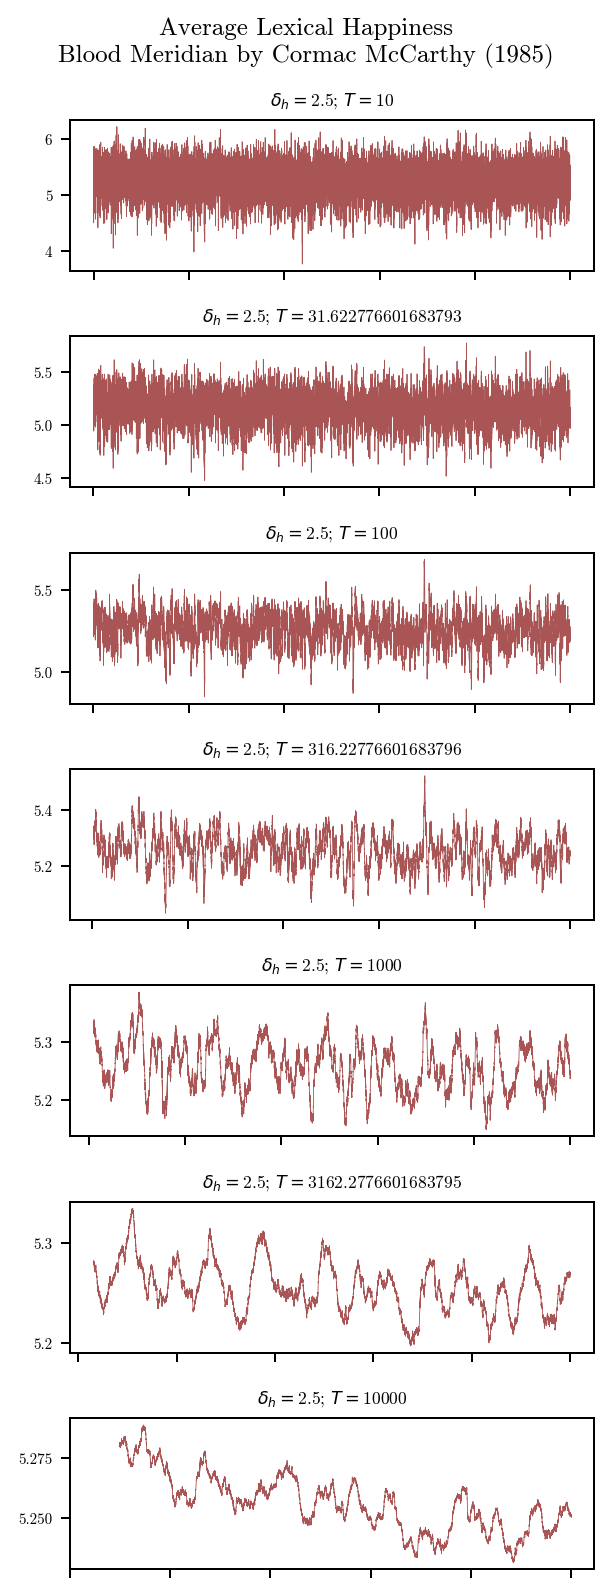

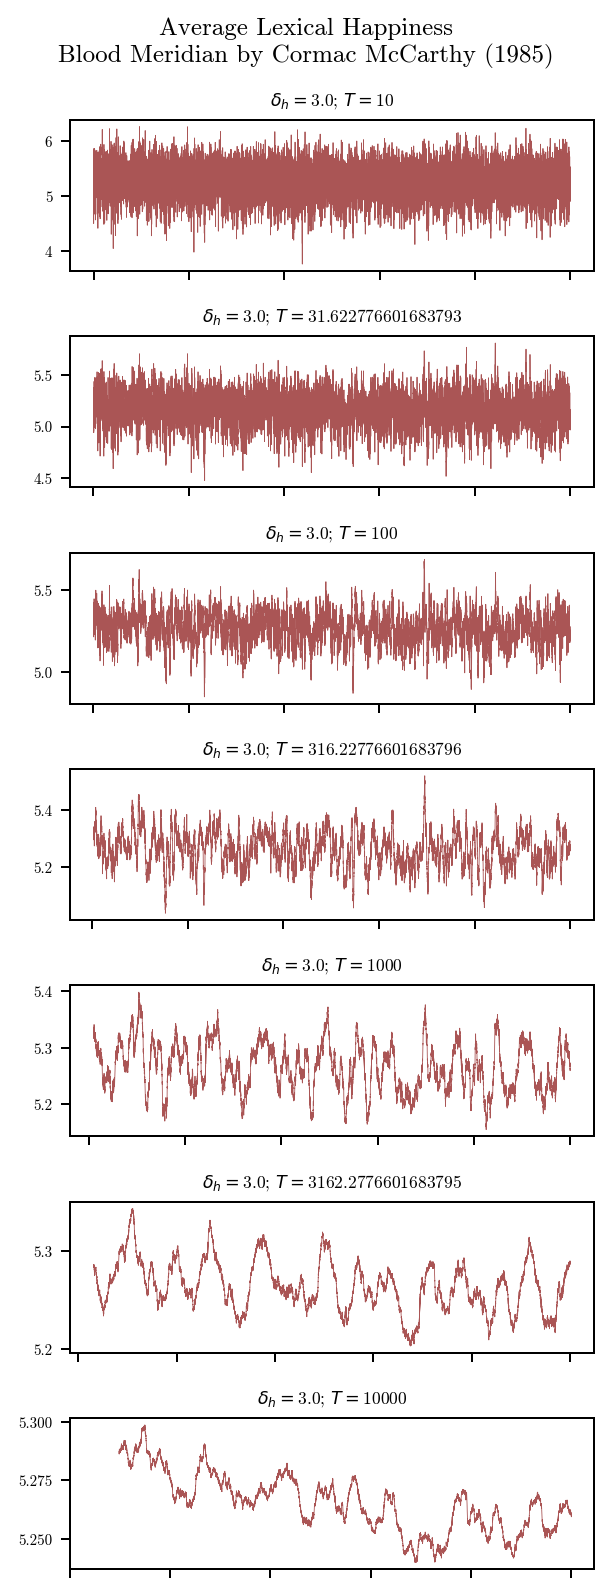

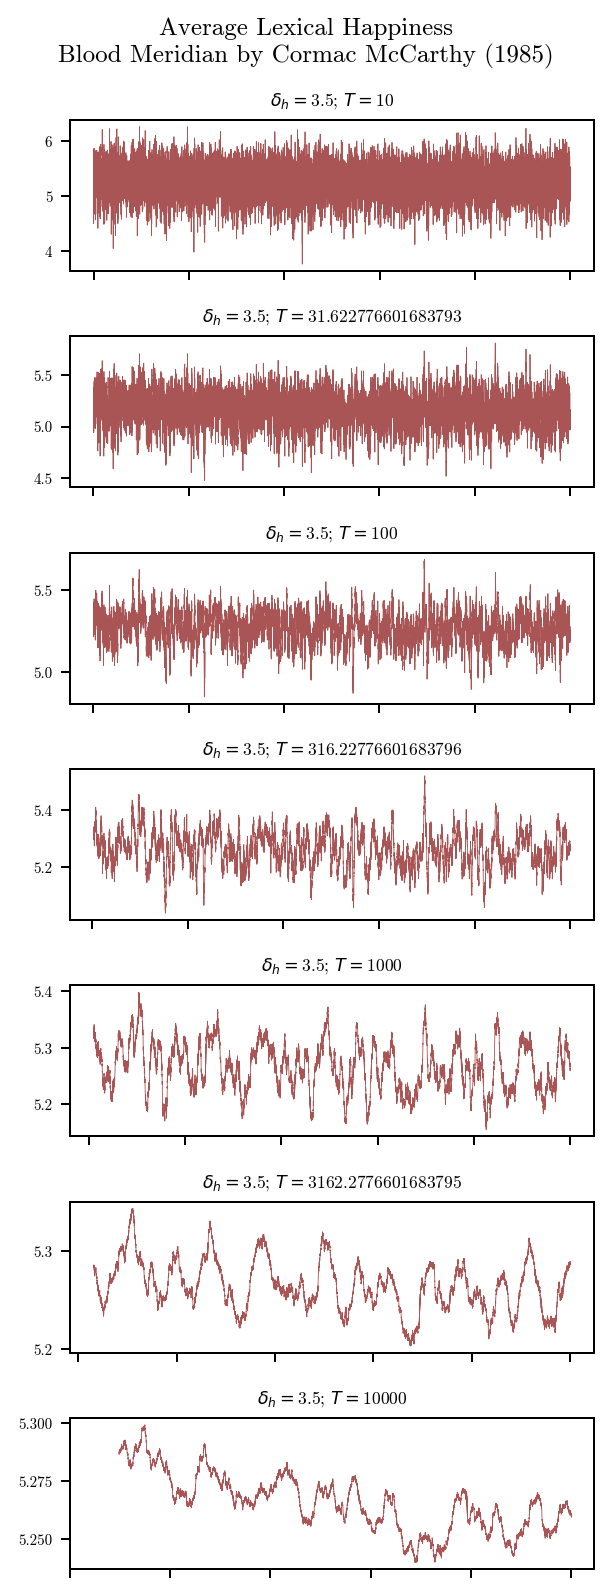

In [14]:
dh = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
t = [10**1, 10**1.5, 10**2, 10**2.5, 10**3, 10**3.5, 10**4]

for i in dh:
    fig, axs = plt.subplots(7, 1, figsize = (3.5, 9), dpi = 180)
    for j, ax in enumerate(axs):
        temp = pd.DataFrame(subdue_ts_df(ts_df, i))
        temp = temp.rolling(int(t[j])).sum() / t[j]
        temp.plot(ax = ax,
                  alpha = 2/3,
                  linewidth = 1/3,
                  color='maroon',
                  legend = False)
        ax.set_title(r'$\delta_h=$'+f'{i}; '+r'$T=$'+f'{t[j]}',
                     fontsize = 7)
        n = len(temp)
        ticks = [int(i) for i in np.linspace(1, n, 6)]
        ax.set_xticks(ticks)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize = 6)

        if i != 3.5:
            ax.set_xticklabels([], fontsize = 6)
    plt.suptitle('Average Lexical Happiness\nBlood Meridian by Cormac McCarthy (1985)',
                   fontsize = 10)
    fig.tight_layout()
    fig.savefig(fname = f'bm_h{i}_T{int(t[j])}.jpg')
    plt.show()

## Question 2
<a id='Question_2'></a>

****

Using your text of choice,
generate word shifts comparing two "interesting" regions of text.

Use the Python package described [here](https://github.com/ryanjgallagher/shifterator).

Various MATLAB versions made by REDACTED do exist and need to shared.

Links to paper versions (arXiv is always best), 
Github repository,
and an exhilarating Twitter feed can be found [here](https://pdodds.w3.uvm.edu/research/papers/gallagher2021a/).

"Interesting" is anything you find interesting.

Could be books 3 and 12 in a series;
the second half of a book compared to the first half;
season 4 of a show versus all seasons;
etc.

Aim to find two texts that are both reasonably large (more than $10^{4}$ words)
and fairly different in average happiness scores.

(Though even the same scores can be meaningfully explored with word shifts)

Let's call the two texts
$T^{(A)}$
and
$T^{(B)}$.

In your plots, you should label them meaningfully based on your choices).

Use a reasonable exclusion lens of your choice, e.g., $[4, 6]$ or $[3, 7]$.

****

### Part a.
<a id='Part_2a'></a>

****


****

### Part b.
<a id='Part_2b'></a>

****


****

### Part c.
<a id='Part_2c'></a>

****


****

### Part d.
<a id='Part_2d'></a>

****


****

### Part e.
<a id='Part_2e'></a>

****


****

### Part f.
<a id='Part_2f'></a>

****


****

# Appendices
<a id='Appendices'></a>

## Hedonometer API
<a id='Hedonometer_API'></a>

In [29]:
def hedo_api():
    """
    API Links:
    https://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2
    ...
    ...
    ...
    """
    %pip install requests

    import requests
    import pandas as pd
    import json

    fmt   = 'json'
    date  = '2018-01-01'
    limit = '10000'
    base = f'http://hedonometer.org/api/v1/events/?format={fmt}&'
    uri = f'{base}happs__timeseries__title=en_all&'
    uri = f'{uri}happs__date__gte={date}&limit={limit}'
    req   = requests.get(uri)
    return pd.DataFrame(json.loads(req.content)['objects'])


def split_hedo_df(happiness_df: pd.core.frame.DataFrame = hedo_api()):
    date = np.array([i['date'] for i in happiness_df['happs']])
    freq = np.array([i['frequency'] for i in happiness_df['happs']])
    haps = np.array([i['happiness'] for i in happiness_df['happs']])
    time = np.array([i['timeseries'] for i in happiness_df['happs']])
    return date, freq, haps, time

Note: you may need to restart the kernel to use updated packages.


## Citations and References
<a id='Citations_and_References'></a>

```
@article{10.1371/journal.pone.0026752,
    doi = {10.1371/journal.pone.0026752},
    author = {
      Dodds, Peter Sheridan 
      AND Harris, Kameron Decker 
      AND Kloumann, Isabel M. 
      AND Bliss, Catherine A. 
      AND Danforth, Christopher M.
    },
    journal = {PLOS ONE},
    publisher = {Public Library of Science},
    title = {
      Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter
    },
    year = {2011},
    month = {12},
    volume = {6},
    url = {https://doi.org/10.1371/journal.pone.0026752},
    pages = {1-1},
    abstract = {
      Individual happiness is a fundamental societal metric.
      Normally measured through self-report, happiness has often 
      been indirectly characterized and overshadowed by more 
      readily quantifiable economic indicators such as gross 
      domestic product. Here, we examine expressions made on the 
      online, global microblog and social networking service 
      Twitter, uncovering and explaining temporal variations in 
      happiness and information levels over timescales ranging 
      from hours to years. Our data set comprises over 46 billion 
      words contained in nearly 4.6 billion expressions posted 
      over a 33 month span by over 63 million unique users. 
      In measuring happiness, we construct a tunable, real-time, 
      remote-sensing, and non-invasive, text-based hedonometer. 
      In building our metric, made available with this paper, 
      we conducted a survey to obtain happiness evaluations of 
      over 10,000 individual words, representing a tenfold size 
      improvement over similar existing word sets. Rather than 
      being ad hoc, our word list is chosen solely by frequency 
      of usage, and we show how a highly robust and tunable 
      metric can be constructed and defended.
    },
    number = {12}
}

@Misc{dodds2014a,
  author = {
    Dodds, P. S.
    and Clark, E. M.
    and Desu, S.
    and Frank, M. R.
    and Reagan, A. J.
    and  Williams, J. R.
    and Mitchell, L.
    and Harris, K. D.
    and Kloumann, I. M.
    and Bagrow, J. P.
    and Megerdoomian, K.
    and McMahon, M. T.
    and Tivnan, B. F.
    and Danforth, C. M.
  },
  title = {
    Human language reveals a universal positivity bias
  },
  OPThowpublished = {},
  OPTmonth = 	 {},
  year = {
    2014
  },
  note = 
  {
    Preprint available at
    \href{http://arxiv.org/abs/1406.3855}{http://arxiv.org/abs/1406.3855}
  },
  OPTannote = 	 {}
}

@Article{gallagher2021a,
  author =	 {
    Gallagher, Ryan J. 
    and Frank, Morgan R. 
    and Mitchell, Lewis 
    and Schwartz, Aaron J. 
    and Reagan, Andrew J. 
    and Danforth, Christopher M. 
    and Dodds, Peter Sheridan
  },
  title =	 {
    Generalized word shift graphs: 
    A method for visualizing and 
    explaining pairwise comparisons between texts
  },
  journal =	 {EPJ Data Science},
  year =	 {2021},
  key =	 {
    systems,
    text,
    words,
    divergences,
    entropy,
    language
  },
  volume =	 {10},
  pages =	 {4},
  note =	 {
    Available online at 
    \href{https://arxiv.org/abs/2008.02250}{https://arxiv.org/abs/2008.02250}
  },
}
```










